This notebook evaluates performance gains of `CudaCosineGreedy` against `matchms`.

Performance depends heavily on used hardware, as well as how correlated the spectra are with each other, (i.e. on average, how many common pairs of peaks do spectra have).

This specific notebook evaulates the performance given the following below arguments (feel free to change these):

In [1]:
# We compare pairwise similarity performance on `spectra_file`
# We can use pickled version for much faster loading times
spectra_file = 'ALL_GNPS.pickle'

# We take a random sample of spectra from said file

# Minimum size:
chunk_sizes_min = 32

# Maximum size
chunk_sizes_max = 4096 # Colab GPU is miserable, so we make this smaller here....

# how many points to evaluate (in logspace) between min and max
num_evals = 15

# max number of peaks to retain in any spectra - larger numbers are marginally more accurate, but much slower
max_peaks = 1024

# optimal batch size is hardware-dependent, but usually the best number is the largest the hardware can handle (without an OOM error)
batch_size = 2048

# Hardware matters! These results are only repeatable using this GPU (shown as an output)
! nvidia-smi -L
! echo Number of CPU cores $(nproc)

GPU 0: Tesla T4 (UUID: GPU-dd33e699-718c-4769-263b-3ccf5fc7fe91)
Number of CPU cores 2


In [2]:
# Colab environment needs numpy==1.24 or less, so we have to do this beforehand.
! pip uninstall -qy numpy
! pip install -q --no-dependencies numpy==1.24
! pip uninstall cudams -q -y
! pip install -q --no-dependencies git+https://github.com/tornikeo/cosine-similarity@main

import numpy as np
np.__version__

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


'1.24.0'

In [3]:
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
from cudams.utils import argbatch, Timer
from cudams.similarity.spectrum_similarity_functions import cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt
import torch

assert cuda.is_available()

In [5]:
import pickle
from cudams.utils import download
from joblib import Parallel, delayed
from matchms.filtering import default_filters, normalize_intensities, reduce_to_number_of_peaks
from matchms.importing import load_from_mgf
from cudams.utils import get_device_name_as_str, mute_stdout

spectra = pickle.load(open(download(spectra_file),'rb'))

/usr/local/lib/python3.10/dist-packages/cudams/utils.py:243: UserWarning: As of 2024, ALL_GNPS.pickle is a large file (1.76GB) make sure the machine can handle this
  warnings.warn(f"As of 2024, {name} is a large file (1.76GB) make sure the machine can handle this")
100%|█████████████████████████████████████| 1.47G/1.47G [00:00<00:00, 1.30TB/s]
SHA256 hash of downloaded file: 473593b86b35de9bc90c216b70ca7f64628bf577cb4bc64afd1d4d0a533ab1f9
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [6]:
from cudams.similarity import CudaCosineGreedy

np.random.seed(42)
chunk_sizes = np.round(np.logspace(
    np.log2(chunk_sizes_min),
    np.log2(chunk_sizes_max),
    num=num_evals,
    base=2,
    endpoint=True)
).astype(int)

times = []
pairs = []

# Kernel compilation might take a bit of time initially
kernel = CudaCosineGreedy(batch_size=batch_size)

# To force CUDA to load code to GPU, we need to do warmup
kernel.matrix(spectra[:64], spectra[:64])

# We avoid parallel here, since we only have one GPU, after all.
for chunk_size in tqdm(chunk_sizes):
    chunk_size = min(len(spectra), chunk_size) # We might run out of spectra
    references = spectra[:chunk_size]
    queries = references # Pairwise
    with Timer() as timer:
        kernel.matrix(references, queries)
    times.append(timer.duration)
    pairs.append(len(references) * len(queries)) # We've processed all pairs

100%|██████████| 15/15 [08:55<00:00, 35.67s/it] 


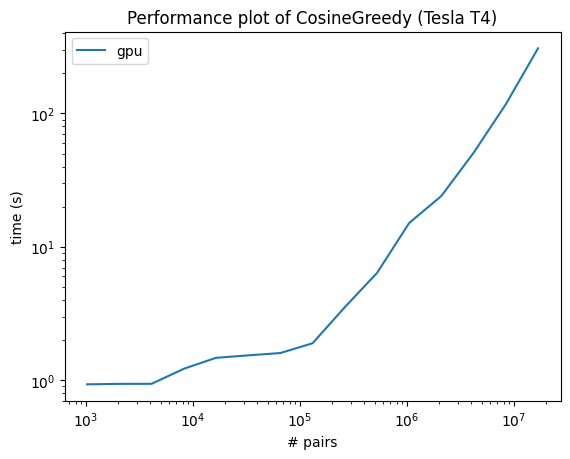

In [9]:
plt.loglog(pairs, times, label='gpu')
plt.title(f"Performance plot of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

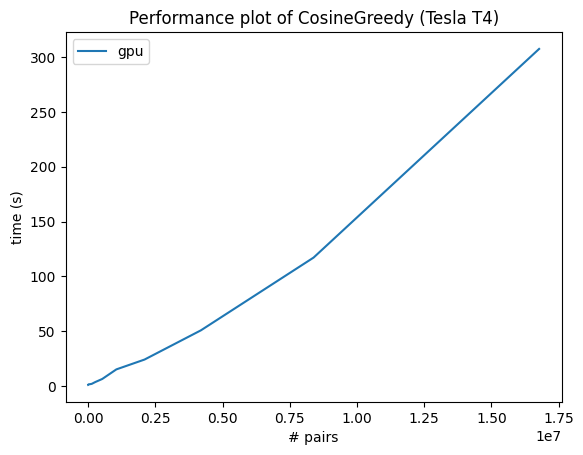

In [11]:
plt.plot(pairs, times, label='gpu')
plt.title(f"Performance plot of CosineGreedy ({torch.cuda.get_device_name()})")
plt.xlabel("# pairs")
plt.ylabel("time (s)")
plt.legend()
plt.show()

In [10]:
import json, os

benchmark_summary = dict(
        pairs=pairs,
        times=times,
        device=torch.cuda.get_device_name(),
        nproc=os.cpu_count(),
    )
print(json.dumps(benchmark_summary,indent=1))

{
 "pairs": [
  1024,
  2025,
  4096,
  8281,
  16384,
  32761,
  65536,
  131044,
  262144,
  524176,
  1048576,
  2096704,
  4194304,
  8386816,
  16777216
 ],
 "times": [
  0.9332277150000436,
  0.9405126579999887,
  0.9414207849999912,
  1.2243749110000408,
  1.4739638879999575,
  1.537869397999998,
  1.601218743000004,
  1.8953012860000626,
  3.531102654000051,
  6.3728779780000195,
  15.107737008000072,
  24.074336751000033,
  50.74331069499999,
  117.12675006699999,
  307.51109804299995
 ],
 "device": "Tesla T4",
 "nproc": 2
}
